In [1]:
import numpy as np
import matplotlib.pyplot as plt

Clustering works well on Gaussians. So we will make some artifical data based on Gaussians.

In [40]:
# Create the 2D Gaussians. 
# len(params): # of clusters
# len(params[0]): # of features
# len(params[0][0]): mean and variance
params = [[[ 0,1],  [ 0,1]], 
          [[ 5,1],  [ 5,1]], 
          [[-2,1],  [ 2,1]],
          [[ 2,1],  [ 2,1]],
          [[-5,1],  [-5,1]]]

# Number of instances per cluster
n = 30
dims = len(params[0])

# Save the data and their associated labels
data = []
y = []
for ix, i in enumerate(params):
    inst = np.random.randn(n, dims)
    for dim in range(dims):
        inst[:,dim] = params[ix][dim][0]+params[ix][dim][1]*inst[:,dim]
        label = ix + np.zeros(n)
        
    if len(data) == 0: data = inst
    else: data = np.append( data, inst, axis= 0)
    if len(y) == 0: y = label
    else: y = np.append(y, label)
        
num_clusters = len(params)

print(y.shape)
print(data.shape)

(150,)
(150, 2)


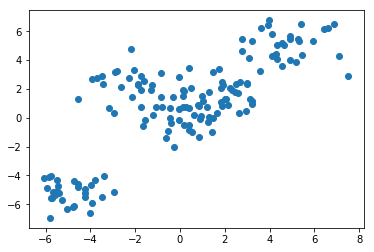

In [41]:
plt.scatter(data[:,0], data[:,1])
plt.show()

In [56]:
class Kmeans(object):
    
    def __init__(self, k=1):
        self.k = k
        self.centroids = None
    
    ################################################
    ########## Training Methods ####################
    ################################################
    def init_centroids(self, data):
        """ We want to initialize k centroids. 
        
        We do not know the range of the data. If a centroid
        falls too far away from the data it will never be able 
        to move closer towards it associated cluster. Thus we want
        to go through the data and identify the range of its values
        for each dimension. 
        
        """
        # Get the shape of the data
        # shape[0]: number of instances
        # shape[1]: number of features
        shape = data.shape
        
        # We will get the minimum and maximum of 
        # each feature in the dataset. The features
        # are the columns.
        # The ranges matrix has dimensions (#features X 2)
        # 2 is for the minimum and maximum value.
        ranges = np.zeros((shape[1], 2))
        for dim in range(shape[1]):
            ranges[dim, 0] = np.min(data[:,dim])
            ranges[dim, 1] = np.max(data[:,dim])
        
        # We will then create k centroids. Each centroid has
        # the same dimensionality as the data. It live in the 
        # same space as these datapoints. 
        # For each centroid we will identify a random value between
        # the minimum and maximum for each feature.
        centroids = np.zeros((self.k, shape[1]))
        for i in range(self.k):
            for dim in range(shape[1]):
                centroids[i, dim] = np.random.uniform(ranges[dim, 0], 
                                                      ranges[dim, 1], 1)
        self.centroids = centroids
    
    def distance_to_centroids(self, data, centroids):
        """ Distance from each datapoint to each centroid.
        
        We want to identify the distance from each datapoint to
        each centroid.
        
        """
        # Get the shape of the data
        # shape[0]: number of instances
        # shape[1]: number of features
        shape = data.shape
        
        # We will get the distance from each datapoint
        # to each centroid. 
        # The distances matrix has dimensions 
        # (#instances X #centroids)
        distances = np.zeros((shape[0],self.k))
        # For each data instance
        for ix, i in enumerate(data):
            # For each centroid
            for ic, c in enumerate(centroids):
                # Calculate the distance
                distances[ix, ic] = np.sqrt(np.sum((i-c)**2))
        return distances
    
    def update_centroids(self, data, labels):
        """ Find the update centroids
        
        Based on the centorid label associated for each dataset. 
        We will then find the center of all these datapoints and
        this will be the new centorid.
        
        """
        # Get the shape of the data
        # shape[0]: number of instances
        # shape[1]: number of features
        shape = data.shape
        
        # We will find the new value of the centroids. 
        # The new_centroids matrix has dimensions 
        # (#centroids X #features)
        new_centroids = np.zeros((self.k, shape[1]))
        for centroid in range(self.k):
            # Extract all the datapoints for each centroid
            temp = data[labels == centroid]
            
            # If no datapoints for a specific centroid
            # then we have an error and we will reinitialize
            # the centroids.
            if len(temp) == 0:
                return None
            
            # For each feature in the extracted datapoints
            # get the average value.
            for dim in range(shape[1]): 
                new_centroids[centroid, dim] = np.mean(temp[:,dim])
        return new_centroids
    
    def train(self, data, verbose=1):
        """ Train the k-means algorithm
        
        Train the centroids to identify the clusters.
        """
        
        shape = data.shape
        
        # Initialize centroids.
        self.init_centroids(data)
        centroids = self.centroids 
        
        # Draw the initialize centroids.
        if verbose == 1:
            print('Centroids: ')
            print(centroids)
            plt.scatter(data[:,0], data[:,1])
            plt.scatter(centroids[:,0], centroids[:,1], c = 'r')
            plt.show()
        
        iteration = 0
        while iteration < 100:
            iteration += 1
            
            # Get the distance from each datapoint to each centroid
            distances = self.distance_to_centroids(data, centroids)
            # Identify the new label for each datapoint.
            labels = np.argmin(distances, axis = 1)
            # Get the new centroids
            new_centroids = self.update_centroids(data, labels)
            
            # Flag the error
            if new_centroids is None:
                return 0
            
            # Plot the data and the new centroids
            if verbose == 1:
                print('-----------------------------------------------')
                print('Iteration: ', iteration)
                plt.scatter(data[:,0], data[:,1], c = labels)
                plt.scatter(new_centroids[:,0], new_centroids[:,1], c = 'r')
                plt.show()
            
            # Verify convergence. If the centorids
            # are in the same place as the last then we are done.
            if np.linalg.norm(new_centroids - centroids) < np.finfo(float).eps:
                print("DONE!")
                break
                
            centroids = new_centroids
        
        # When we are done.
        # We will save the centroids and labels
        self.centroids = centroids
        self.labels = labels
        
        if verbose == 1:
            print(labels)
            print(centroids)
        return 1
    
    ################################################
    ########## Additional Methods ##################
    ################################################
    def getAverageDistance(self, data):
        dists = np.zeros((len(self.centroids),))
        for ix, centroid in enumerate(self.centroids):
            temp = data[self.labels == ix]
            dist = 0
            for i in temp:
                dist += np.linalg.norm(i - centroid)
            dists[ix] = dist/len(temp)
        return dists
    
    def getLabels(self):
        return self.labels

-----------------------------------------------
Iteration:  1


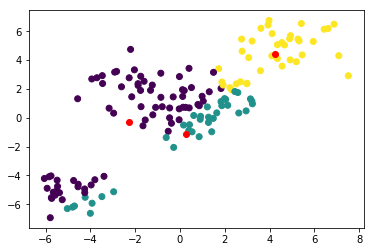

-----------------------------------------------
Iteration:  2


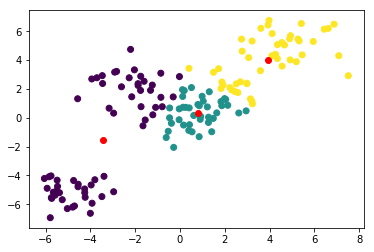

-----------------------------------------------
Iteration:  3


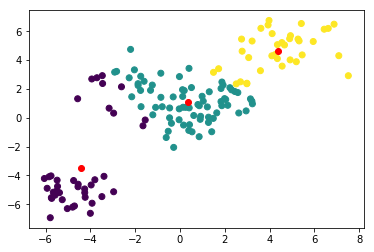

-----------------------------------------------
Iteration:  4


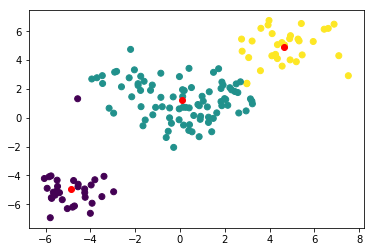

-----------------------------------------------
Iteration:  5


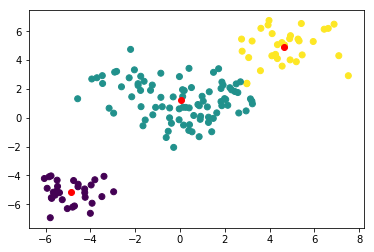

-----------------------------------------------
Iteration:  6


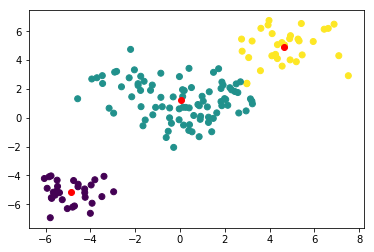

DONE!
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[[-4.86623983 -5.16954897]
 [ 0.0265233   1.23117635]
 [ 4.66937782  4.87451128]]


In [58]:
kmeans = Kmeans(3)

temp = kmeans.train(data)
while temp == 0:
    temp = kmeans.train(data)

K-means with k:  1
DONE!
K-means with k:  2
DONE!
K-means with k:  3
DONE!
K-means with k:  4
DONE!
K-means with k:  5
DONE!
K-means with k:  6
DONE!
K-means with k:  7
DONE!
K-means with k:  8
DONE!
K-means with k:  9
DONE!
K-means with k:  10
DONE!


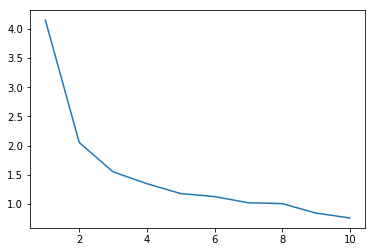

Real number of clusters: 5


In [55]:
k = [1,2,3,4,5,6,7,8,9,10]
avg_dists = np.zeros((len(k),))

temp = 0
for ix, i in enumerate(k):
    print('K-means with k: ', i)
    kmeans = Kmeans(i)
    while temp == 0:
        temp = kmeans.train(data, 0)
    temp = 0
    avg_dists[ix] = np.mean(kmeans.getAverageDistance(data))
    
plt.plot(range(1, len(avg_dists)+1), avg_dists)
plt.show()

print('Real number of clusters:', num_clusters)